In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import json

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

get some basic info of data files

In [2]:
# ValueError: could not convert string to float: '8789-0'
def read_data_partial(given_fname, output_fname, lim=399999):
    content = []
    count = 1

    with open(given_fname, 'r') as fr:
        for line in fr:
            if count <= lim:
                #print(type(line), line)
                content.append(line)
                count += 1
    with open(output_fname, 'w') as fw:
        for line in content:
            # print(type(line), line)
            fw.write(line)
    
    data = pd.read_csv(output_fname, index_col=False)

    return data

## drop u, g, r bands

In [3]:
qso_train_partial = read_data_partial('quasar_train_catalog.csv', 'qso_train_partial.csv')
qso_train_drop = qso_train_partial[['z', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
qso_train_drop = qso_train_drop.replace(99.99, np.nan).dropna()
qso_train_drop = qso_train_drop[qso_train_drop['z'] < 7.5]
redshifts26 = qso_train_drop[qso_train_drop['z_LSST_mag'] > 22.0]
redshifts26 = redshifts26[redshifts26['z_LSST_mag'] < 26.0]
redshifts26 = redshifts26['z']
qso_train_drop = qso_train_drop.drop(columns=['z'])
print('qso_train_catalog_z.csv partial data description: ')
qso_train_drop.describe()

qso_train_catalog_z.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,20759.000000,20759.000000,20759.000000,20759.000000,20759.000000,20759.000000
mean,28.576193,26.616020,24.340320,24.201112,24.264969,24.132527
std,1.218340,1.654428,2.009015,2.089360,2.112093,2.108081
min,26.672280,23.064283,18.489759,17.989148,17.800595,17.633615
25%,27.689657,25.314514,23.136710,22.977195,23.069490,22.937156
50%,28.366448,26.540555,24.371926,24.306130,24.363508,24.192066
75%,29.189413,27.668971,25.789820,25.697926,25.766767,25.595761
max,38.902328,36.769079,32.115011,32.168396,32.742341,33.953075


(array([1986., 1725., 1511., 1102.,   95.,   74.,  366.,  489.,  380.,
         271.]),
 array([6.0001027 , 6.15004544, 6.29998818, 6.44993092, 6.59987366,
        6.7498164 , 6.89975914, 7.04970188, 7.19964462, 7.34958736,
        7.4995301 ]),
 <BarContainer object of 10 artists>)

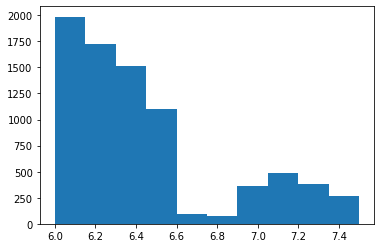

In [4]:
plt.hist(redshifts26)

In [5]:
# brown dwarf contaminants
mlt_train_partial = read_data_partial('mlt_train_catalog.csv', 'mlt_train_partial.csv', 599999)
mlt_train_drop = mlt_train_partial[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
mlt_train_drop = mlt_train_drop.replace(99.99, np.nan).dropna()
print('mlt_train_catalog_z.csv partial data description: ')
mlt_train_drop.describe()

mlt_train_catalog_z.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,40214.000000,40214.000000,40214.000000,40214.000000,40214.000000,40214.000000
mean,27.846368,26.406966,24.814492,24.240174,23.941983,23.954949
std,0.866569,0.814599,0.652285,0.636041,0.633281,0.639802
min,26.565172,24.640153,22.966413,22.249321,21.884903,21.705643
25%,27.248302,25.848580,24.336131,23.782914,23.500752,23.511550
50%,27.631546,26.262440,24.722560,24.157117,23.877029,23.890512
75%,28.185010,26.792519,25.207176,24.619579,24.324040,24.337251
max,38.215437,36.198974,28.369839,27.735964,27.180561,27.305963


In [6]:
galaxies_patch8789_partial = read_data_partial('galaxies_train_catalog_patch8789.csv', 'galaxies_patch8789_partial.csv')
galaxies_patch8789_drop = galaxies_patch8789_partial[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8789_drop = galaxies_patch8789_drop.replace(99.99, np.nan).dropna()
print('galaxies_train_catalog_patch8789.csv partial data description: ')
galaxies_patch8789_drop.describe()

galaxies_train_catalog_patch8789.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,166180.000000,166180.000000,166180.000000,166180.000000,166180.000000,166180.000000
mean,28.112741,27.507701,27.330679,27.226355,27.160891,27.154280
std,0.888656,0.950758,0.788433,0.796900,0.827853,0.977009
min,26.647539,25.462982,25.152190,24.748167,24.475726,24.258516
25%,27.518918,26.883531,26.837638,26.737179,26.657671,26.557470
50%,27.920273,27.314756,27.248012,27.172407,27.118375,27.041903
75%,28.465759,27.895376,27.710084,27.634895,27.594613,27.601858
max,40.029429,39.261958,39.647494,40.707497,38.204669,38.379259


In [7]:
galaxies_patch8786_partial = read_data_partial('galaxies_train_catalog_patch8786.csv', 'galaxies_patch8786_partial.csv')
galaxies_patch8786_drop = galaxies_patch8786_partial[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8786_drop = galaxies_patch8786_drop.replace(99.99, np.nan).dropna()
print('galaxies_train_catalog_patch8786.csv partial data description: ')
galaxies_patch8786_drop.describe()

galaxies_train_catalog_patch8786.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,156946.000000,156946.000000,156946.000000,156946.000000,156946.000000,156946.000000
mean,28.100839,27.494196,27.312890,27.205311,27.141593,27.131091
std,0.886168,0.952284,0.787836,0.803832,0.842035,0.981601
min,26.573603,25.553776,25.107279,24.705397,24.460871,24.280885
25%,27.507428,26.871497,26.818026,26.714657,26.633417,26.535331
50%,27.905549,27.298753,27.235470,27.156032,27.102195,27.024873
75%,28.452895,27.883019,27.697073,27.620384,27.584425,27.588162
max,40.812877,40.422024,37.436853,38.037623,37.411129,37.630643


### drop missing values

In [8]:
print(qso_train_drop.head(), len(qso_train_drop))
print(np.where(np.isnan(qso_train_drop)))
print(len(mlt_train_drop))
print(np.where(np.isnan(mlt_train_drop)))
print(len(galaxies_patch8789_drop))
print(np.where(np.isnan(galaxies_patch8789_drop)))
print(len(galaxies_patch8786_drop))
print(np.where(np.isnan(galaxies_patch8786_drop)))

      i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag
1281   27.955360   23.388638  18.489759  18.079326  18.072496  18.058461
1307   27.672539   23.363093  18.584296  18.061424  18.042225  18.025975
1329   28.051408   23.778138  18.601250  18.008757  17.881144  17.780953
1344   27.538063   23.893443  18.537558  18.022577  17.954901  17.866836
1350   27.028989   24.008393  18.589781  18.074683  17.986391  17.954758 20759
(array([], dtype=int64), array([], dtype=int64))
40214
(array([], dtype=int64), array([], dtype=int64))
166180
(array([], dtype=int64), array([], dtype=int64))
156946
(array([], dtype=int64), array([], dtype=int64))


In [9]:
qso_train_drop['label'] = np.ones(len(qso_train_drop))
mlt_train_drop['label'] = np.zeros(len(mlt_train_drop))
galaxies_patch8789_drop['label'] = np.zeros(len(galaxies_patch8789_drop))
galaxies_patch8786_drop['label'] = np.zeros(len(galaxies_patch8786_drop))

### check the cleaned datasets and concatenate into new ones

In [10]:
print('qso:\n', qso_train_drop.head())
print('bd:\n', mlt_train_drop.head())
print('galaxies patch8789:\n', galaxies_patch8789_drop.head())
print('galaxies path8786:\n', galaxies_patch8786_drop.head())

qso:
       i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
1281   27.955360   23.388638  18.489759  18.079326  18.072496  18.058461   
1307   27.672539   23.363093  18.584296  18.061424  18.042225  18.025975   
1329   28.051408   23.778138  18.601250  18.008757  17.881144  17.780953   
1344   27.538063   23.893443  18.537558  18.022577  17.954901  17.866836   
1350   27.028989   24.008393  18.589781  18.074683  17.986391  17.954758   

      label  
1281    1.0  
1307    1.0  
1329    1.0  
1344    1.0  
1350    1.0  
bd:
         i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
398247   26.888214   24.767034  24.160454  23.807130  23.455427  23.446447   
398253   26.758145   25.077703  24.012978  23.724390  23.529321  23.489750   
398350   26.817520   25.070334  24.192246  23.774151  23.644759  23.551041   
398458   26.976849   25.348521  24.372349  23.913859  23.949639  23.681874   
398464   26.788703   25.283402  24.121468  23.827350  23.8

In [11]:
# data concatenation to get training data
contaminants_drop = pd.concat([mlt_train_drop, galaxies_patch8789_drop, galaxies_patch8786_drop], ignore_index=True)
data_train_drop = pd.concat([qso_train_drop, contaminants_drop], ignore_index=True) # make sure that the data line up
X_drop = data_train_drop[['i_LSST_mag', 'z_LSST_mag','Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
Y_drop = data_train_drop['label']

In [12]:
print(len(X_drop))

384099


In [13]:
X_drop.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,384099.000000,384099.000000,384099.000000,384099.000000,384099.000000,384099.000000
mean,28.105037,27.338747,26.898356,26.741610,26.659483,26.646531
std,0.916743,1.058480,1.320838,1.417921,1.468364,1.548313
min,26.565172,23.064283,18.489759,17.989148,17.800595,17.633615
25%,27.487583,26.729171,26.520257,26.375729,26.271044,26.171445
50%,27.903062,27.208934,27.103179,27.019502,26.959260,26.869193
75%,28.471100,27.809780,27.602659,27.530272,27.490765,27.470353
max,40.812877,40.422024,39.647494,40.707497,38.204669,38.379259


## 24.0 < z < 26

In [14]:
qso_train_26 = qso_train_drop[qso_train_drop['z_LSST_mag'] > 24.0]
qso_train_26 = qso_train_26[qso_train_26['z_LSST_mag'] < 26.0]
print(len(qso_train_26))
mlt_train_26 = mlt_train_drop[mlt_train_drop['z_LSST_mag'] > 24.0]
mlt_train_26 = mlt_train_26[mlt_train_26['z_LSST_mag'] < 26.0]
print(len(mlt_train_26))
galaxies_patch8789_26 = galaxies_patch8789_drop[galaxies_patch8789_drop['z_LSST_mag'] > 24.0]
galaxies_patch8789_26 = galaxies_patch8789_26[galaxies_patch8789_26['z_LSST_mag'] < 26.0]
print(len(galaxies_patch8789_26))
galaxies_patch8786_26 = galaxies_patch8786_drop[galaxies_patch8786_drop['z_LSST_mag'] > 24.0]
galaxies_patch8786_26 = galaxies_patch8786_26[galaxies_patch8786_26['z_LSST_mag'] < 26.0]
print(len(galaxies_patch8786_26))

7514
13790
778
753


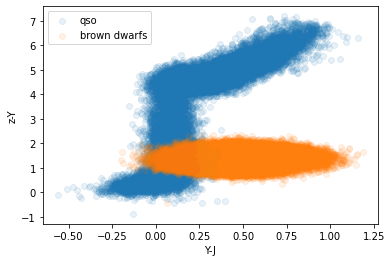

In [40]:
plt.scatter(qso_train_26['Y_WFI_mag']-qso_train_26['J_WFI_mag'], qso_train_26['z_LSST_mag']-qso_train_26['Y_WFI_mag'], label='qso', alpha=0.1)
plt.scatter( mlt_train_26['Y_WFI_mag']-mlt_train_26['J_WFI_mag'], mlt_train_26['z_LSST_mag']-mlt_train_26['Y_WFI_mag'], label='brown dwarfs', alpha=0.1)
# plt.scatter(galaxies_patch8789_26['z_LSST_mag']-galaxies_patch8789_26['Y_WFI_mag'], galaxies_patch8789_26['i_LSST_mag']-galaxies_patch8789_26['z_LSST_mag'], label='galaxies', alpha=0.01)
plt.legend()
plt.xlabel('Y-J')
plt.ylabel('z-Y')
plt.show()

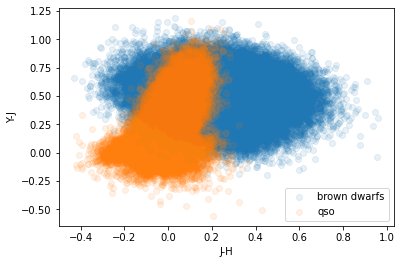

In [41]:
plt.scatter(mlt_train_26['J_WFI_mag']-mlt_train_26['H_WFI_mag'], mlt_train_26['Y_WFI_mag']-mlt_train_26['J_WFI_mag'], label='brown dwarfs', alpha=0.1)
plt.scatter(qso_train_26['J_WFI_mag']-qso_train_26['H_WFI_mag'], qso_train_26['Y_WFI_mag']-qso_train_26['J_WFI_mag'], label='qso', alpha=0.1)
# plt.scatter(galaxies_patch8789_26['J_WFI_mag']-galaxies_patch8789_26['H_WFI_mag'], galaxies_patch8789_26['Y_WFI_mag']-galaxies_patch8789_26['J_WFI_mag'], label='galaxies', alpha=0.01)
plt.legend()
plt.xlabel('J-H')
plt.ylabel('Y-J')
plt.show()

In [15]:
# data concatenation to get training data
# contaminants_26 = pd.concat([mlt_train_26, galaxies_patch8789_26, galaxies_patch8786_26], ignore_index=True)
# data_train_26 = pd.concat([qso_train_26, contaminants_26], ignore_index=True) # make sure that the data line up
qso_sample = qso_train_26.sample(frac=0.25, replace=False, random_state=42)
print(qso_sample.describe())
mlt_sample = mlt_train_26.sample(frac=0.25, replace=False, random_state=42)
print(mlt_sample.describe())
galaxies_sample = galaxies_patch8786_26.sample(frac=0.25, replace=False, random_state=42)
print(galaxies_sample.describe())

        i_LSST_mag   z_LSST_mag    Y_WFI_mag    J_WFI_mag    H_WFI_mag  \
count  7764.000000  7764.000000  7764.000000  7764.000000  7764.000000   
mean     27.427876    24.995322    21.651059    21.418526    21.432314   
std       1.401830     0.565143     2.058918     2.235890     2.272562   
min      23.788298    24.000073    18.513950    17.982100    17.822507   
25%      26.575116    24.509070    19.917792    19.574341    19.553334   
50%      27.457401    25.004192    20.883465    20.631223    20.654150   
75%      28.234780    25.463842    23.764249    23.708501    23.765565   
max      36.661521    25.999696    26.390650    26.646703    26.504268   

         F_WFI_mag   label  
count  7764.000000  7764.0  
mean     21.318634     1.0  
std       2.215038     0.0  
min      17.740865     1.0  
25%      19.472385     1.0  
50%      20.570842     1.0  
75%      23.582797     1.0  
max      26.959496     1.0  
         i_LSST_mag    z_LSST_mag     Y_WFI_mag     J_WFI_mag     H_WFI_

In [16]:
contaminants_26 = pd.concat([mlt_sample, galaxies_sample], ignore_index=True)
data_train_26 = pd.concat([qso_sample, contaminants_26], ignore_index=True)
X_drop_26 = data_train_26[['i_LSST_mag', 'z_LSST_mag','Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
Y_drop_26 = data_train_26['label']

In [17]:
col_names = ['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']
for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i < j:
            col = col_names[i] + '-' + col_names[j]
            X_drop_26[col] = X_drop_26[col_names[i]] - X_drop_26[col_names[j]]

X_drop_26_copy = X_drop_26.drop(columns=['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag'])

/data0/sw/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


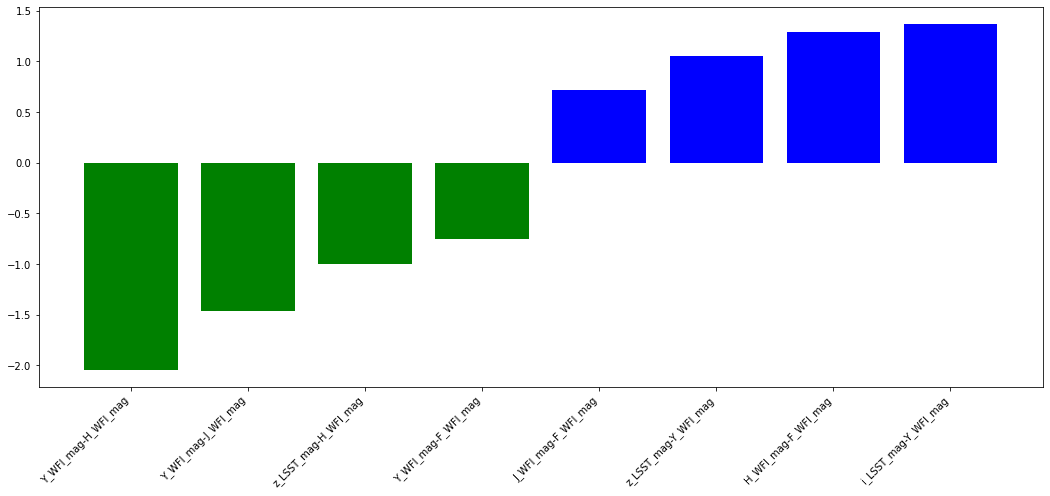

In [45]:
trainedsvm = svm.LinearSVC(max_iter = 2000).fit(X_drop_26_copy, Y_drop_26)
coef = trainedsvm.coef_.ravel()

top_positive_coefficients = np.argsort(coef)[-4:]
top_negative_coefficients = np.argsort(coef)[:4]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
plt.figure(figsize=(18, 7))
colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * 4), coef[top_coefficients], color=colors)
feature_names = np.array(X_drop_26_copy.columns)
plt.xticks(np.arange(2 * 4), feature_names[top_coefficients], rotation=45, ha='right')
plt.show()

In [18]:
# keep the columns with the highest influences & check if the dataframes look reasonable
# with z-band limits
# same features as the full data one
X_drop_26 = X_drop_26[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'Y_WFI_mag-H_WFI_mag', 'Y_WFI_mag-J_WFI_mag', 'z_LSST_mag-H_WFI_mag', 'Y_WFI_mag-F_WFI_mag', 'J_WFI_mag-F_WFI_mag', 'z_LSST_mag-Y_WFI_mag', 'H_WFI_mag-F_WFI_mag', 'i_LSST_mag-Y_WFI_mag']]

print(type(X_drop_26))
print('X with 24.0 < z < 26.0: \n', X_drop_26.head())

<class 'pandas.core.frame.DataFrame'>
X with 24.0 < z < 26.0: 
    i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
0   27.065472   25.794110  22.100631  22.029062  22.205613  22.057968   
1   28.583702   25.980188  26.187396  26.202393  26.282175  26.012154   
2   27.010937   25.257756  20.480374  20.277014  20.353868  20.332721   
3   27.151121   24.139281  18.863139  18.341580  18.352961  18.370204   
4   27.771398   24.461827  23.732094  23.583951  23.654046  23.504111   

   Y_WFI_mag-H_WFI_mag  Y_WFI_mag-J_WFI_mag  z_LSST_mag-H_WFI_mag  \
0            -0.104983             0.071569              3.588497   
1            -0.094779            -0.014997             -0.301987   
2             0.126506             0.203360              4.903888   
3             0.510178             0.521559              5.786321   
4             0.078049             0.148144              0.807781   

   Y_WFI_mag-F_WFI_mag  J_WFI_mag-F_WFI_mag  z_LSST_mag-Y_WFI_mag  \
0            

In [19]:
X_drop_26_copy = X_drop_26.copy()

In [20]:
print(len(X_drop_26_copy))

53127


### color-color plots to decide which combinations should be used for decision boundaries 

check which ones are the most "separable"

In [20]:
import seaborn as sns

In [88]:
def color_plot(X, x_lab, y_lab):
    q = sns.jointplot(data=X, x=x_lab, y=y_lab, hue='label', kind='scatter', joint_kws={"alpha": 0.3})

### 22.0 < z < 26.0

In [30]:
X_drop_26_copy['label'] = Y_drop_26

/data0/sw/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1598: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


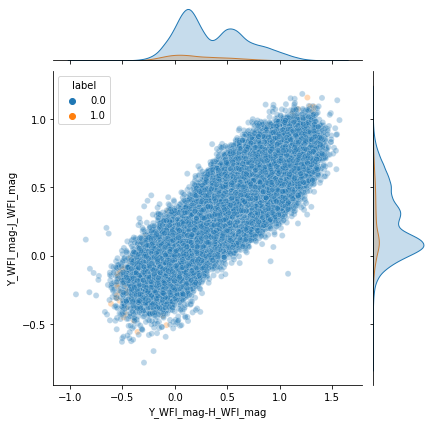

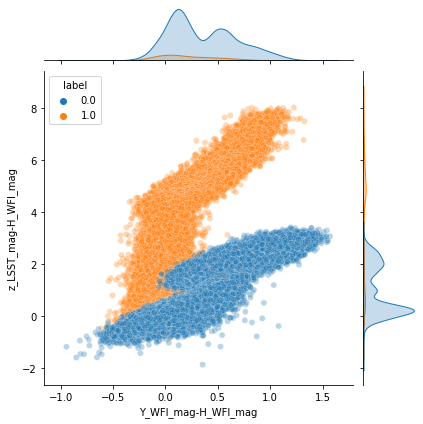

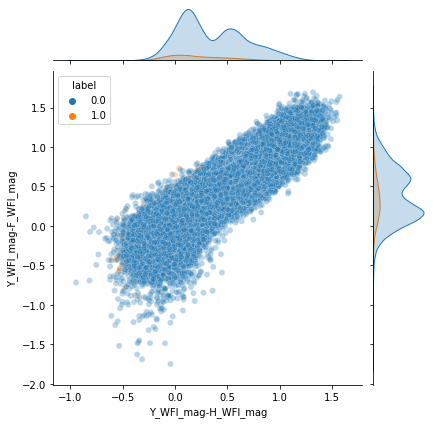

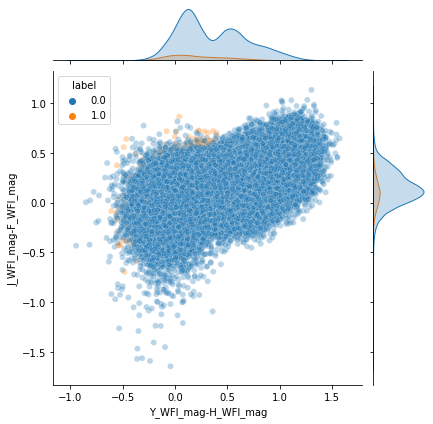

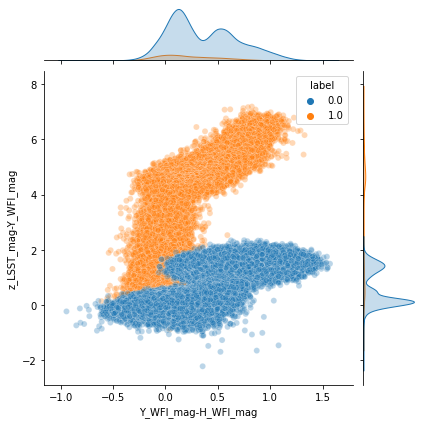

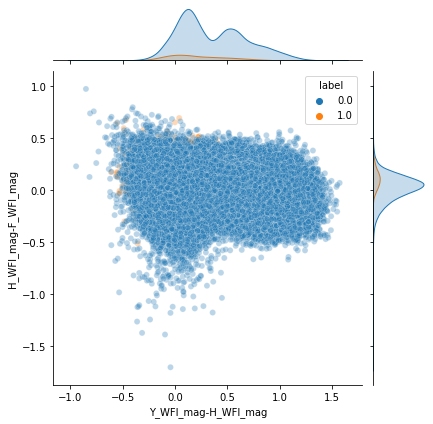

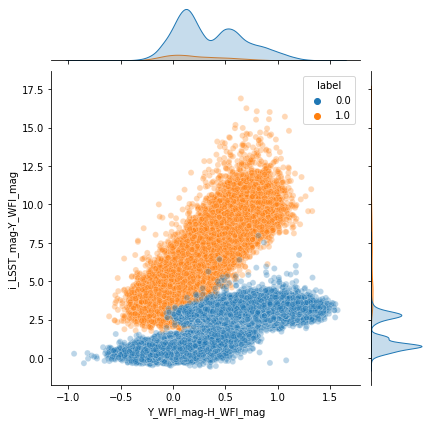

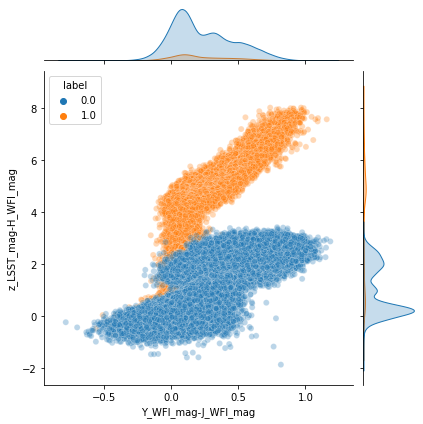

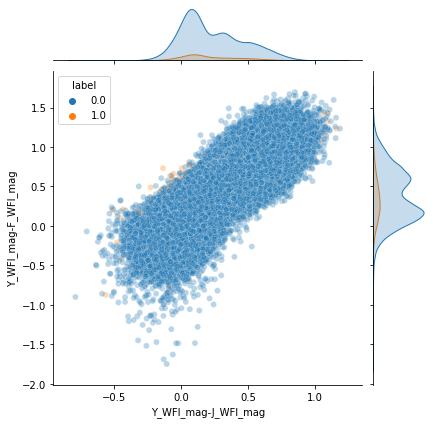

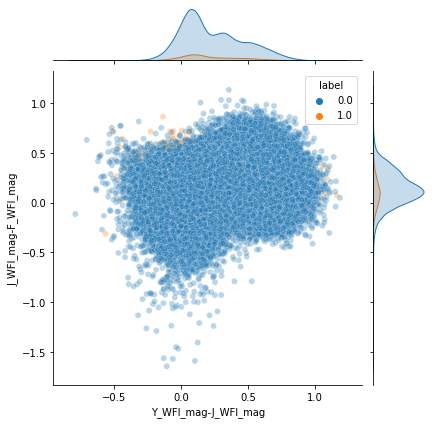

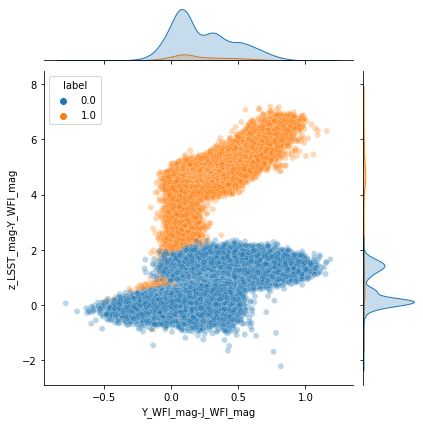

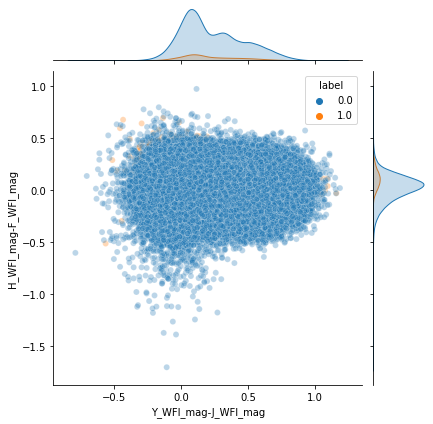

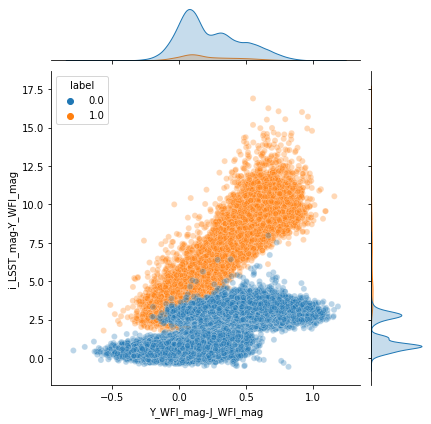

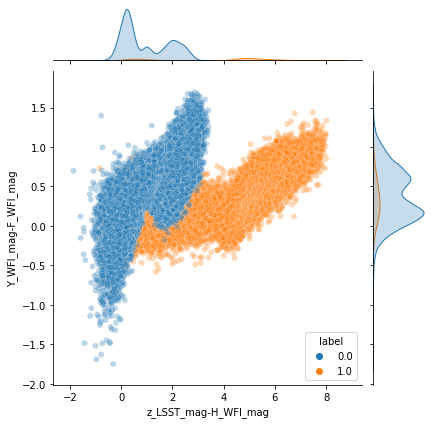

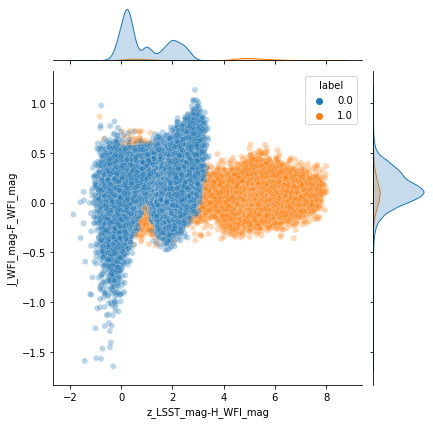

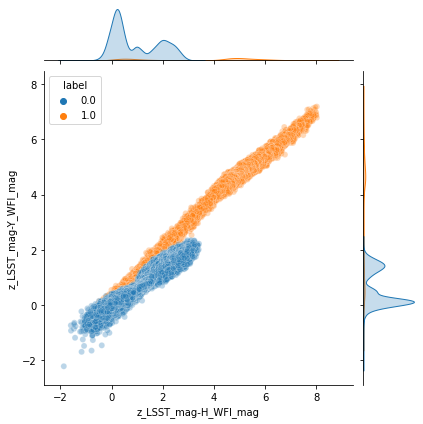

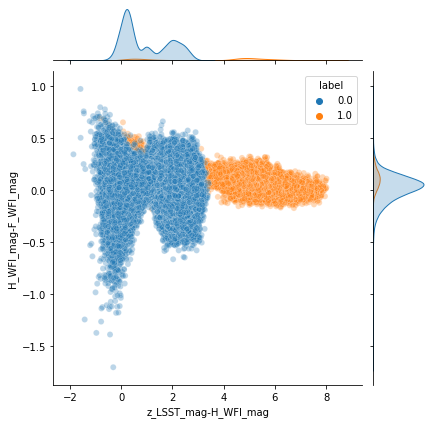

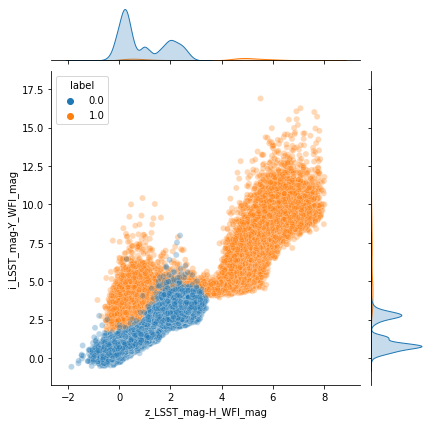

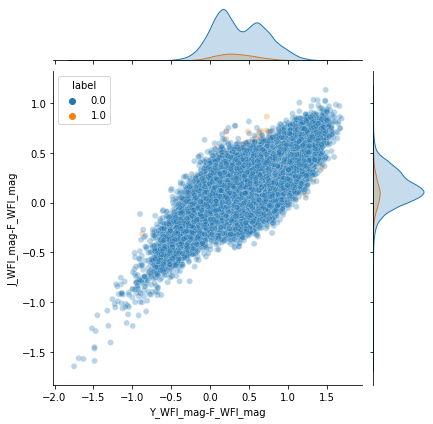

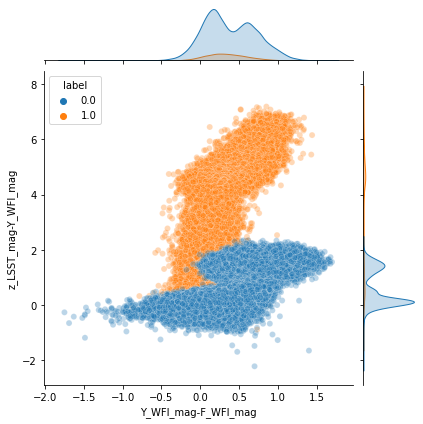

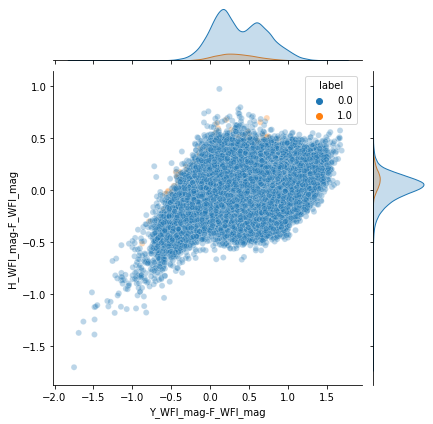

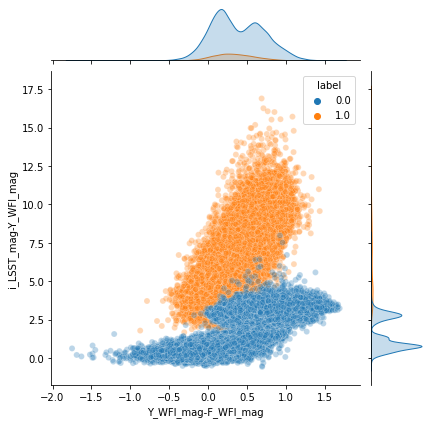

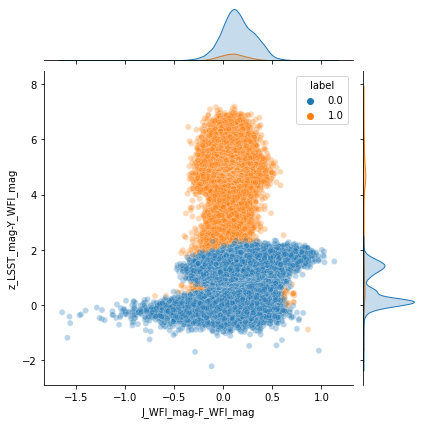

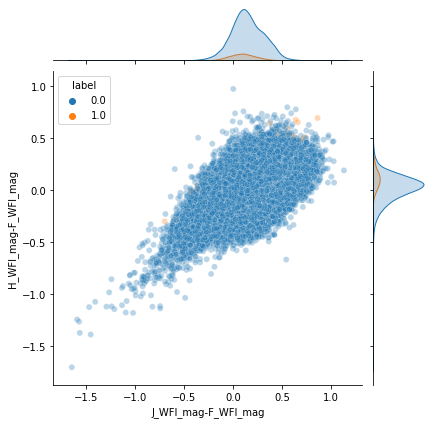

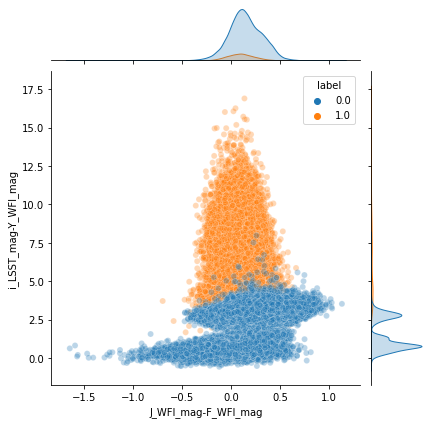

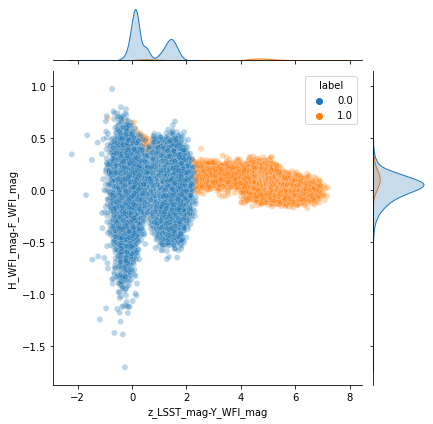

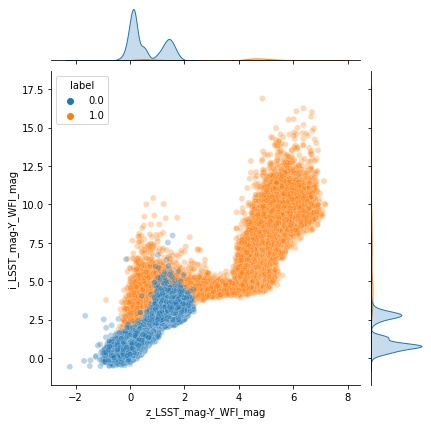

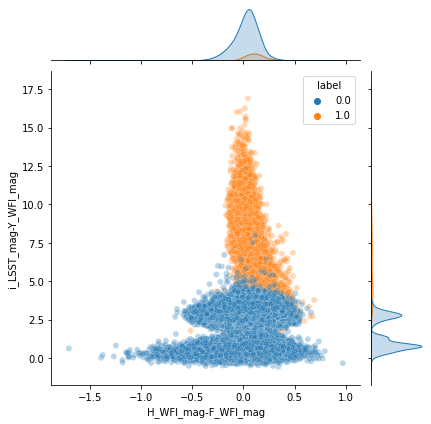

In [31]:
cols = X_drop_26_copy.columns
# print(len(cols))

for i in range(6, 14):
    x_lab = cols[i]
    # range may change later 
    for j in range(i+1, 14):
        y_lab = cols[j]
        color_plot(X_drop_26_copy, x_lab, y_lab)

In [32]:
X_drop_26_copy = X_drop_26_copy.drop(columns=['label'])

## KNN Training

In [21]:
from numba import jit, cuda

In [22]:
@jit(forceobj=True, parallel=True) 
def knn_training(x1, x2, y1, y2, y, n, leaves):
    # format x1: X['r']
    # type: n -> list of integers
    features = [x1-x2, y1-y2]
    X = np.array(features).transpose()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    grid_params = {'n_neighbors' : n,
                   'leaf_size': leaves,
                   'weights' :  ['uniform','distance'],
                   'metric' : ['minkowski','euclidean','manhattan'],
                  'p': [1, 2, 3, 4, 5, 6],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

    gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
    g_res = gs.fit(X_train, y_train)

    print('best score: ', g_res.best_score_)
    print('best params: ', g_res.best_params_)

In [23]:
def get_color_filter(clf, n_neighbors, weights, x1, x2, y1, y2, y):
    # Create color maps
    cmap_light = ListedColormap(['#75aff9', '#f7a844']) # blue, orange
    cmap_bold = ListedColormap(['#8dbcf9', '#f5a844']) 
    
    features = [x1-x2, y1-y2]
    X = np.array(features).transpose()

    # we create an instance of Neighbours Classifier and fit the data.
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = min(x1 - x2) - 1, max(x1 - x2) + 1
    y_min, y_max = min(y1 - y2) - 1, max(y1 - y2) + 1
    h = (x_max-x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.15)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, alpha=0.2)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.title("k = %i, weights = '%s'"
              % (n_neighbors, weights))

### 24 < z < 26

In [36]:
'''df = pd.merge(X_drop_26, Y_drop_26, left_index=True, right_index=True)
df_sample = df.sample(frac=0.2, replace=False, random_state=42)
X_drop_26 = df_sample[['i_LSST_mag', 'z_LSST_mag','Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
Y_drop_26 = df_sample['label']
X_drop_26.describe()
'''

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,11709.000000,11709.000000,11709.000000,11709.000000,11709.000000,11709.000000
mean,26.116176,25.053203,24.181070,23.947816,23.837226,23.806893
std,0.871774,0.573809,1.406169,1.534235,1.568392,1.573892
min,23.876356,24.000076,18.425039,17.989267,17.777493,17.644537
25%,25.556980,24.567909,23.538468,23.100501,22.903083,22.899564
50%,26.029177,25.078962,24.378330,24.194332,24.092037,24.029017
75%,26.528911,25.551617,25.187844,25.102287,25.033796,24.985818
max,32.325255,25.999857,26.770695,26.893492,27.113379,27.996091


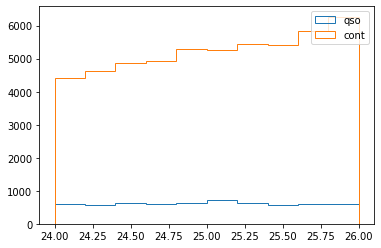

In [24]:
plt.hist(df_sample['z_LSST_mag'][df_sample['label'] == 1], histtype='step', label='qso')
plt.hist(df_sample['z_LSST_mag'][df_sample['label'] == 0], histtype='step', label='cont')
plt.legend()
plt.show()

try Y-J/ z-Y -> don't work

Y-J z-H don't work well; best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 40, 'p': 1, 'weights': 'uniform'}

Y - J i - Y high train score, don't work well; best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 19, 'p': 2, 'weights': 'uniform'}

Y-J H-F don't work well; best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 35, 'p': 1, 'weights': 'uniform'}

Y-J Y-H don't work well; best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 40, 'p': 5, 'weights': 'uniform'}

Y-J J-F don't work well; best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 26, 'p': 3, 'weights': 'uniform'}

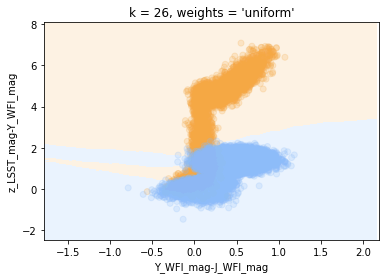

In [60]:
# x: Y - J
# y: z - Y

filter1g = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=26, leaf_size=3, weights='uniform', p=3)
get_color_filter(filter1g, 26, 'uniform', X_drop_26['Y_WFI_mag'], X_drop_26['J_WFI_mag'], X_drop_26['z_LSST_mag'], X_drop_26['Y_WFI_mag'], Y_drop_26)
plt.xlabel('Y_WFI_mag-J_WFI_mag')
plt.ylabel('z_LSST_mag-Y_WFI_mag')
plt.show()

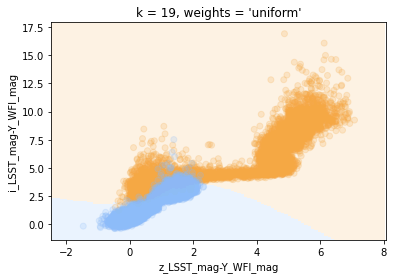

In [28]:
# x: z - Y
# y: i - Y
# best score:  0.9940572227600302
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 19, 'p': 2, 'weights': 'uniform'}
# knn_training(X_drop_26['z_LSST_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['i_LSST_mag'], X_drop_26['Y_WFI_mag'], Y_drop_26, [13, 19, 26, 30, 35, 36, 40], [3, 5])

filter1d = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=19, leaf_size=3, weights='uniform', p=2)
get_color_filter(filter1d, 19, 'uniform', X_drop_26['z_LSST_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['i_LSST_mag'], X_drop_26['Y_WFI_mag'], Y_drop_26)
plt.xlabel('z_LSST_mag-Y_WFI_mag')
plt.ylabel('i_LSST_mag-Y_WFI_mag')
plt.show()

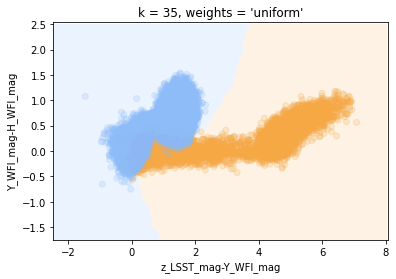

In [26]:
# x: z - Y
# y: Y - H
# best score:  0.9833279552543832
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 35, 'p': 4, 'weights': 'uniform'}
# best score:  0.9833817360438851
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 60, 'p': 6, 'weights': 'uniform'}
# knn_training(X_drop_26['z_LSST_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['H_WFI_mag'], Y_drop_26, [26, 30, 35, 36, 40, 50, 60], [3, 5])

filter1e = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=35, leaf_size=3, weights='uniform', p=4)
get_color_filter(filter1e, 35, 'uniform', X_drop_26['z_LSST_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['H_WFI_mag'], Y_drop_26)
plt.xlabel('z_LSST_mag-Y_WFI_mag')
plt.ylabel('Y_WFI_mag-H_WFI_mag')
plt.show()

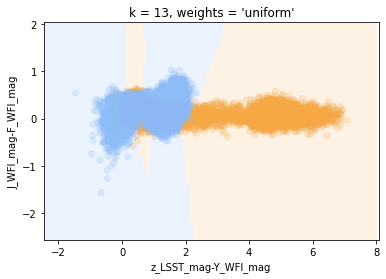

In [29]:
# x: z - Y
# y: J - F
# best score:  0.956787135635151
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}
# knn_training(X_drop_26['z_LSST_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['J_WFI_mag'], X_drop_26['F_WFI_mag'], Y_drop_26, [7, 13, 19, 26, 30, 35, 36, 40], [3, 5, 6])

filter1f = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=13, leaf_size=3, weights='uniform', p=2)
get_color_filter(filter1f, 13, 'uniform', X_drop_26['z_LSST_mag'], X_drop_26['Y_WFI_mag'], X_drop_26['J_WFI_mag'], X_drop_26['F_WFI_mag'], Y_drop_26)
plt.xlabel('z_LSST_mag-Y_WFI_mag')
plt.ylabel('J_WFI_mag-F_WFI_mag')
plt.show()

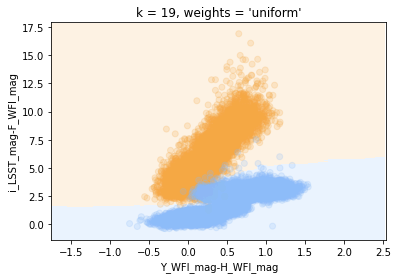

In [30]:
# x: Y - H
# y: i - Y
# knn_training(X_drop_26['Y_WFI_mag'], X_drop_26['H_WFI_mag'], X_drop_26['i_LSST_mag'], X_drop_26['Y_WFI_mag'], Y_drop_26, [26, 5, 7, 21, 19, 15, 30], [3, 5, 6, 8])
# best score:  0.9955571430594082
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 19, 'p': 3, 'weights': 'uniform'}

filter1a = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=19, leaf_size=3, weights='uniform', p=3)
get_color_filter(filter1a, 19, 'uniform', X_drop_26['Y_WFI_mag'], X_drop_26['H_WFI_mag'], X_drop_26['i_LSST_mag'], X_drop_26['Y_WFI_mag'], Y_drop_26)
plt.xlabel('Y_WFI_mag-H_WFI_mag')
plt.ylabel('i_LSST_mag-F_WFI_mag')
plt.show()

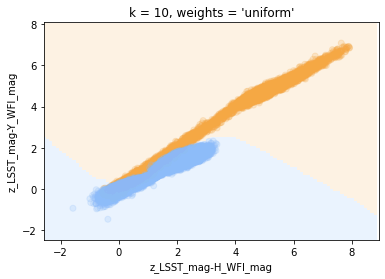

In [31]:
# x: z - H
# y: z - Y
# knn_training(X_drop_26['z_LSST_mag'], X_drop_26['H_WFI_mag'], X_drop_26['z_LSST_mag'], X_drop_26['Y_WFI_mag'], Y_drop_26, [5, 10, 15, 21, 26, 30], [3, 5, 6, 8])
# best score:  0.9940143030585334
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 5, 'weights': 'uniform'}

filter1b = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=10, leaf_size=3, weights='uniform', p=5)
get_color_filter(filter1b, 10, 'uniform', X_drop_26['z_LSST_mag'], X_drop_26['H_WFI_mag'], X_drop_26['z_LSST_mag'], X_drop_26['Y_WFI_mag'], Y_drop_26)
plt.xlabel('z_LSST_mag-H_WFI_mag')
plt.ylabel('z_LSST_mag-Y_WFI_mag')
plt.show()

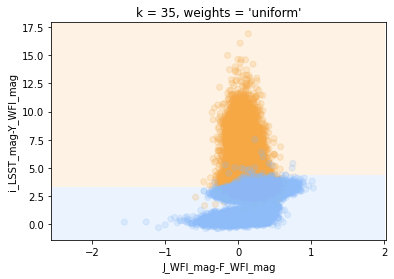

In [32]:
# x: J - F
# y: i - Y
# knn_training(X_drop_26['J_WFI_mag'], X_drop_26['F_WFI_mag'], X_drop_26['i_LSST_mag'], X_drop_26['Y_WFI_mag'], Y_drop_26, [10, 19, 26, 30, 40], [3, 5, 8])
# best score:  0.98103953147877
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 35, 'p': 1, 'weights': 'uniform'}
# best score:  0.9566714291659798
# best params:  {'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 60, 'p': 3, 'weights': 'uniform'}
'''
features2 = [X_drop_26['J_WFI_mag']- X_drop_26['F_WFI_mag'], X_drop_26['i_LSST_mag']- X_drop_26['Y_WFI_mag']]
X2 = np.array(features2).transpose()
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y_drop_26, test_size=0.3, random_state=42)
grid_params = { 'n_neighbors' : [19, 26, 35, 40, 50, 60],
                'leaf_size': [3, 5, 8],
                'weights' :  ['uniform','distance'],
                'metric' : ['minkowski','manhattan'],
                'p': [1, 2, 3],
                'algorithm': ['auto']}

gs2 = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
g_res2 = gs2.fit(X2_train, y2_train)

print('best score: ', g_res2.best_score_)
print('best params: ', g_res2.best_params_)
'''
filter1c = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=35, leaf_size=3, weights='uniform', p=1)
get_color_filter(filter1c, 35, 'uniform', X_drop_26['J_WFI_mag'], X_drop_26['F_WFI_mag'], X_drop_26['i_LSST_mag'], X_drop_26['Y_WFI_mag'], Y_drop_26)
plt.xlabel('J_WFI_mag-F_WFI_mag')
plt.ylabel('i_LSST_mag-Y_WFI_mag')
plt.show()

# Test- 24 < z < 26

In [33]:
# retrieve redshift for later usage
qso_test = pd.read_csv('quasar_test_catalog.csv', index_col=False)
qso_test = qso_test[['z', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
qso_test = qso_test.replace(99.99, np.nan).dropna()
# qso_test = qso_test[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
qso_test.describe()

,z,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,9649.000000,9649.000000,9649.000000,9649.000000,9649.000000,9649.000000,9649.000000
mean,6.373137,28.464186,26.420427,25.490640,25.432698,25.458672,25.266174
std,0.378367,1.628431,2.081829,2.156326,2.162477,2.147925,2.137884
min,6.000043,21.400500,18.803401,18.181244,18.048911,17.986569,17.740505
25%,6.113808,27.602889,24.958309,23.896123,23.831924,23.882998,23.700056
50%,6.260255,28.505566,26.661654,25.541368,25.493465,25.522946,25.351914
75%,6.499256,29.340931,27.831248,27.086576,27.048172,27.065559,26.839999
max,9.659032,36.776360,37.164003,35.672331,36.651372,34.514265,34.889903


In [34]:
galaxies_patch8788 = read_data_partial('galaxies_train_catalog_patch8788.csv', 'galaxies_patch8788_245.csv', 30000)
galaxies_patch8788 = galaxies_patch8788.replace(99.99, np.nan).dropna()
galaxies_patch8788 = galaxies_patch8788[['z', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8788_26 = galaxies_patch8788[(galaxies_patch8788['z_LSST_mag']>24.0)&(galaxies_patch8788['z_LSST_mag']<26.0)]
print('galaxies_train_catalog_patch8788.csv data description: ')
galaxies_patch8788.describe()

galaxies_train_catalog_patch8788.csv data description: 


,z,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000,20750.000000
mean,1.032609,25.064565,24.472561,24.263562,24.133942,24.032490,23.970953
std,0.014266,1.258280,1.250795,1.294158,1.348217,1.403003,1.451221
min,1.005989,20.738443,20.199310,19.730171,19.315425,18.971169,18.750817
25%,1.020363,24.321473,23.749411,23.524088,23.357096,23.211484,23.120767
50%,1.033982,25.208614,24.607205,24.439207,24.332423,24.249539,24.205313
75%,1.045150,25.930392,25.342387,25.182842,25.094375,25.045359,25.005333
max,1.055212,32.004925,31.083271,28.285061,28.161714,30.885336,32.729688


In [35]:
mlt_test = read_data_partial('mlt_test_catalog_z.csv', 'mlt_test_catalog_z26.csv', 120000)
mlt_test = mlt_test.sample(frac=0.5, replace=False, random_state=42)
mlt_test = mlt_test[['spt', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
mlt_test = mlt_test.replace(99.99, np.nan).dropna()
mlt_test['z'] = np.zeros(mlt_test.shape[0])
print('mlt_test_catalog partial data description: ')
mlt_test.describe()

mlt_test_catalog partial data description: 


,spt,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,z
count,55055.000000,55055.000000,55055.000000,55055.000000,55055.000000,55055.000000,55055.000000,55055.0
mean,12.385433,26.289625,24.966760,23.489955,22.971737,22.744801,22.793760,0.0
std,4.547707,0.666339,0.581767,0.564113,0.560762,0.562394,0.579325,0.0
min,7.000000,23.039745,24.000046,21.118877,20.590129,20.855618,20.691708,0.0
25%,9.000000,25.788207,24.460829,23.063062,22.572864,22.365763,22.400478,0.0
50%,11.000000,26.246013,24.943436,23.468758,22.965476,22.750433,22.791453,0.0
75%,14.000000,26.747581,25.470492,23.914781,23.380262,23.137921,23.193993,0.0
max,29.000000,32.622297,25.999972,25.525366,25.011076,24.808649,25.154299,0.0


In [36]:
qso_test_copy = qso_test.copy()
qso_test_copy['label'] = np.ones(len(qso_test_copy))
qso_test_copy['spt'] = np.zeros(len(qso_test_copy))
galaxies_patch8788_copy = galaxies_patch8788.copy()
galaxies_patch8788_copy['label'] = np.zeros(len(galaxies_patch8788_copy))
galaxies_patch8788_copy['spt'] = np.zeros(len(galaxies_patch8788_copy))

In [37]:
mlt_test_copy = mlt_test.copy()
mlt_test_copy['label'] = np.zeros(len(mlt_test_copy))
mlt_test_26 = mlt_test[(mlt_test['z_LSST_mag']>24.0)&(mlt_test['z_LSST_mag']<26.0)]
test0 = pd.concat([qso_test_copy, galaxies_patch8788_copy, mlt_test_copy], ignore_index=True)
test = test0[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'label']]
test.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label
count,85454.000000,85454.000000,85454.000000,85454.000000,85454.000000,85454.000000,85454.000000
mean,26.237695,25.010898,23.903709,23.531823,23.363914,23.358778,0.112915
std,1.365856,1.176104,1.250107,1.367503,1.433034,1.396825,0.316490
min,20.738443,18.803401,18.181244,18.048911,17.986569,17.740505,0.000000
25%,25.587594,24.364231,23.128874,22.674765,22.477423,22.498416,0.000000
50%,26.155214,24.945282,23.688663,23.223140,23.003437,23.034564,0.000000
75%,26.823121,25.573188,24.347617,23.976213,23.831265,23.840399,0.000000
max,36.776360,37.164003,35.672331,36.651372,34.514265,34.889903,1.000000


In [38]:
qso_test_26 = qso_test[qso_test['z_LSST_mag'] < 26.0]
qso_test_26 = qso_test_26[qso_test_26['z_LSST_mag'] > 24.0]
qso_test_26_copy = qso_test_26.copy()
print('length of qso test catalog with 24 < z < 26:', len(qso_test_26))

length of qso test catalog with 24 < z < 26: 2407


Objects's z-band distribution before classification:


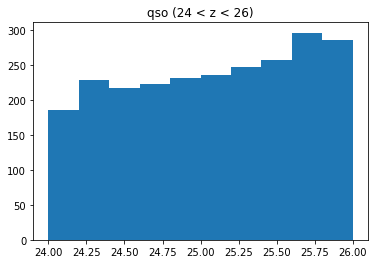

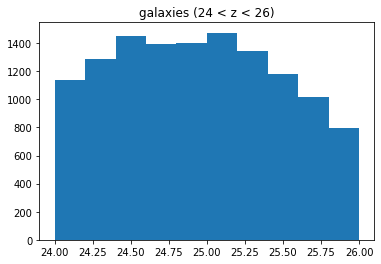

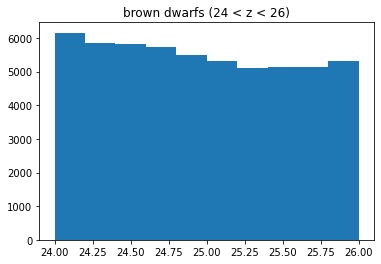

In [39]:
print('Objects\'s z-band distribution before classification:')
plt.hist(qso_test_26['z_LSST_mag'])
plt.title('qso (24 < z < 26)')
plt.show()
plt.hist(galaxies_patch8788_26['z_LSST_mag'])
plt.title('galaxies (24 < z < 26)')
plt.show()
plt.hist(mlt_test_26['z_LSST_mag'])
plt.title('brown dwarfs (24 < z < 26)')
plt.show()

with galaxies added only

In [37]:
test_wgal = pd.concat([qso_test_copy, galaxies_patch8788_copy], ignore_index=True)
test_wgal.describe()

,z,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label
count,30399.000000,30399.000000,30399.000000,30399.000000,30399.000000,30399.000000,30399.000000,30399.000000
mean,2.727755,26.143645,25.090837,24.653051,24.546183,24.485177,24.382072,0.317412
std,2.495042,2.103921,1.807079,1.716168,1.757952,1.802388,1.803237,0.465477
min,1.005989,20.738443,18.803401,18.181244,18.048911,17.986569,17.740505,0.000000
25%,1.026378,24.768484,23.962236,23.604832,23.469275,23.383264,23.292799,0.000000
50%,1.044342,25.798604,24.952712,24.630497,24.536968,24.486993,24.418978,0.000000
75%,6.094547,27.524153,26.014783,25.597830,25.529738,25.495752,25.432340,1.000000
max,9.659032,36.776360,37.164003,35.672331,36.651372,34.514265,34.889903,1.000000


In [38]:
test_wgal_copy = test_wgal.copy()
test_wgal_copy = test_wgal_copy.drop(columns=['label'])
test_wgal_copy = test_wgal_copy[test_wgal_copy['z_LSST_mag'] > 24.0]
test_wgal_copy = test_wgal_copy[test_wgal_copy['z_LSST_mag'] < 26.0]
print(len(test_wgal_copy))

14882


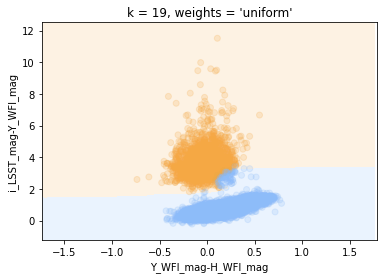

2314


In [39]:
# x: Y - H
# y: i - Y
features1a = [X_drop_26['Y_WFI_mag']-X_drop_26['H_WFI_mag'], X_drop_26['i_LSST_mag']-X_drop_26['Y_WFI_mag']]
X1a = np.array(features1a).transpose()
filter1a.fit(X1a, Y_drop_26)
labels = filter1a.predict(np.array([test_wgal_copy['Y_WFI_mag']-test_wgal_copy['H_WFI_mag'], test_wgal_copy['i_LSST_mag']-test_wgal_copy['Y_WFI_mag']]).transpose())

get_color_filter(filter1a, 19, 'uniform', test_wgal_copy['Y_WFI_mag'], test_wgal_copy['H_WFI_mag'], test_wgal_copy['i_LSST_mag'], test_wgal_copy['Y_WFI_mag'], labels)
plt.xlabel('Y_WFI_mag-H_WFI_mag')
plt.ylabel('i_LSST_mag-Y_WFI_mag')
plt.show()

test_wgal_copy['label'] = labels
test_wgal_copy = test_wgal_copy[test_wgal_copy['label'] == 1]
print(len(test_wgal_copy))

In [40]:
print(test_wgal_copy.merge(qso_test_26))

             z  i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  \
0     6.283538   27.155350   24.060349  23.521693  23.400392  23.467473   
1     6.189466   29.333075   25.541300  25.234170  25.248807  25.159523   
2     6.406638   27.532037   25.116377  24.159598  24.087764  24.303871   
3     6.199295   28.380834   25.834655  25.398672  25.600155  25.617763   
4     6.281061   27.297134   24.478555  23.856727  23.854241  23.983015   
...        ...         ...         ...        ...        ...        ...   
2309  6.007867   27.890372   25.726710  25.898793  26.122272  25.949780   
2310  6.812961   26.026078   25.070786  20.664406  20.571033  20.647334   
2311  6.081216   32.367130   25.202656  25.057222  25.072270  25.119547   
2312  6.341708   27.768646   25.363953  24.653063  24.591199  24.729581   
2313  6.180021   28.343002   25.906369  25.355149  25.347819  25.463067   

      F_WFI_mag  label  
0     23.277673    1.0  
1     24.985900    1.0  
2     24.112669    1.0  

with galaxies and brown dwarfs added

In [65]:
test_copy = test.copy()
test_copy = test_copy[test_copy['z_LSST_mag'] > 24.0]
test_copy = test_copy[test_copy['z_LSST_mag'] < 26.0]
print(len(test_copy))
print(len(test_copy[test_copy['label'] == 1]))

69937
2407


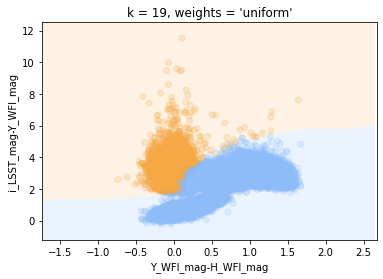

3144


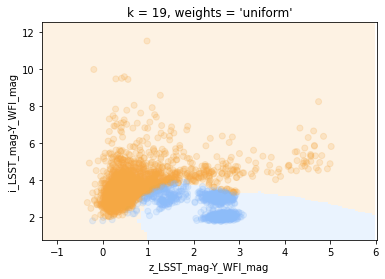

2277


In [66]:
# x: Y - H
# y: i - Y
features1a = [X_drop_26['Y_WFI_mag']-X_drop_26['H_WFI_mag'], X_drop_26['i_LSST_mag']-X_drop_26['Y_WFI_mag']]
X1a = np.array(features1a).transpose()
filter1a.fit(X1a, Y_drop_26)
labels = filter1a.predict(np.array([test_copy['Y_WFI_mag']-test_copy['H_WFI_mag'], test_copy['i_LSST_mag']-test_copy['Y_WFI_mag']]).transpose())

get_color_filter(filter1a, 19, 'uniform', test_copy['Y_WFI_mag'], test_copy['H_WFI_mag'], test_copy['i_LSST_mag'], test_copy['Y_WFI_mag'], labels)
plt.xlabel('Y_WFI_mag-H_WFI_mag')
plt.ylabel('i_LSST_mag-Y_WFI_mag')
plt.show()

test_copy['label'] = labels
test_copy = test_copy[test_copy['label'] == 1]
print(len(test_copy))

# x: z - Y
# y: i - Y
features1d = [X_drop_26['z_LSST_mag']-X_drop_26['Y_WFI_mag'], X_drop_26['i_LSST_mag']-X_drop_26['Y_WFI_mag']]
X1d = np.array(features1d).transpose()
filter1d.fit(X1d, Y_drop_26)
labels = filter1d.predict(np.array([test_copy['z_LSST_mag']-test_copy['Y_WFI_mag'], test_copy['i_LSST_mag']-test_copy['Y_WFI_mag']]).transpose())

get_color_filter(filter1d, 19, 'uniform', test_copy['z_LSST_mag'], test_copy['Y_WFI_mag'], test_copy['i_LSST_mag'], test_copy['Y_WFI_mag'], labels)
plt.xlabel('z_LSST_mag-Y_WFI_mag')
plt.ylabel('i_LSST_mag-Y_WFI_mag')
plt.show()

test_copy['label'] = labels
test_copy = test_copy[test_copy['label'] == 1]
print(len(test_copy))

In [51]:
print(test_copy.merge(qso_test_26))

      i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
0      27.155350   24.060349  23.521693  23.400392  23.467473  23.277673   
1      27.532037   25.116377  24.159598  24.087764  24.303871  24.112669   
2      28.380834   25.834655  25.398672  25.600155  25.617763  25.537893   
3      27.297134   24.478555  23.856727  23.854241  23.983015  23.734303   
4      28.058959   24.955505  24.460251  24.451138  24.515147  24.259397   
...          ...         ...        ...        ...        ...        ...   
1610   27.533729   24.638039  24.020940  23.957343  23.893371  23.622115   
1611   27.363936   24.240421  22.956918  22.828580  22.839162  22.684279   
1612   26.026078   25.070786  20.664406  20.571033  20.647334  20.567169   
1613   27.768646   25.363953  24.653063  24.591199  24.729581  24.545577   
1614   28.343002   25.906369  25.355149  25.347819  25.463067  25.238210   

      label         z  
0       1.0  6.283538  
1       1.0  6.406638  
2       1.0  6.

In [39]:
print(max(test_copy.merge(qso_test_26)['z_LSST_mag']))

25.999146522798828


In [40]:
test_copy.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.0
mean,28.059450,25.056805,24.320634,24.306738,24.338538,24.157761,1.0
std,1.108890,0.578608,0.917908,0.973493,0.957802,0.931188,0.0
min,24.783273,24.000488,19.894535,19.605744,19.448049,19.226805,1.0
25%,27.329779,24.555214,23.857697,23.821432,23.823487,23.653008,1.0
50%,27.908976,25.079475,24.405669,24.395639,24.433133,24.234897,1.0
75%,28.565070,25.564050,24.966567,24.991790,25.010122,24.803789,1.0
max,36.071602,25.999147,26.226358,26.290053,26.707899,26.242381,1.0


In [41]:
qso_test_26.describe()

,z,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000
mean,6.233392,28.018987,25.067872,24.361828,24.353850,24.383288,24.184347
std,0.173726,1.062740,0.577944,0.908388,0.953768,0.937640,0.926207
min,6.000053,24.783273,24.000488,19.894535,19.605744,19.448049,19.226805
25%,6.092341,27.335987,24.565416,23.893320,23.859938,23.892865,23.679095
50%,6.194536,27.871921,25.098967,24.437580,24.445188,24.477617,24.266038
75%,6.346945,28.484820,25.581979,25.011580,25.022900,25.032212,24.821133
max,7.169561,36.071602,25.999147,26.514935,26.760616,26.707899,26.641654


In [47]:
tp = test_copy.merge(qso_test_26)
# qso_test_26 - tp = omitted positives = false negatives
fn = pd.merge(tp, qso_test_26, on=['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag'], how='outer', indicator=True).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)

In [48]:
tp.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label,z
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.0,2155.000000
mean,28.055230,25.024039,24.316100,24.317650,24.350748,24.153662,1.0,6.233294
std,1.105135,0.573317,0.917442,0.969645,0.955218,0.942468,0.0,0.175382
min,24.783273,24.000488,19.894535,19.605744,19.448049,19.226805,1.0,6.000053
25%,27.329140,24.526167,23.851025,23.826714,23.863464,23.653907,1.0,6.092789
50%,27.903829,25.033670,24.398022,24.410321,24.438157,24.236941,1.0,6.194219
75%,28.557054,25.521584,24.961631,24.991437,25.008953,24.804431,1.0,6.343265
max,36.071602,25.999147,26.226358,26.290053,26.707899,26.242381,1.0,7.169561


In [49]:
fn = fn.rename(columns={'z_y': 'z'})
fn = fn[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'z']]
fn.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,z
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,27.709047,25.442711,24.752872,24.663414,24.661560,24.446747,6.234229
std,0.487311,0.472754,0.717715,0.737396,0.714361,0.723392,0.159190
min,26.352693,24.070101,22.740085,22.517794,22.448004,22.196093,6.000534
25%,27.398164,25.220908,24.188348,24.098263,24.141098,23.967340,6.088823
50%,27.730658,25.580865,24.856819,24.768701,24.739183,24.514898,6.210882
75%,28.031320,25.804714,25.304020,25.220008,25.192719,24.931997,6.395066
max,28.997915,25.997626,26.514935,26.760616,26.632869,26.641654,6.537481


In [50]:
# true negative intersect pred positive = false positive
fp = pd.merge(tp, test_copy, on=['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag'], how='outer', indicator=True).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)

In [51]:
fp = fp.rename(columns={'label_y': 'pred label'})
false_positive = test0[test0.z_LSST_mag.isin(fp['z_LSST_mag'])]
false_positive.describe()

,z,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label,spt
count,38.0,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.0,38.000000
mean,0.0,28.858041,25.721513,23.768660,23.374260,23.278007,23.776427,0.0,19.078947
std,0.0,1.469133,0.276184,0.809438,0.735132,0.513523,0.613980,0.0,7.895882
min,0.0,26.145620,24.942517,22.117435,21.600015,22.173345,22.156770,0.0,8.000000
25%,0.0,27.718132,25.584133,23.074883,22.769694,22.929665,23.452643,0.0,13.250000
50%,0.0,29.046008,25.839252,24.163153,23.664647,23.273643,23.827606,0.0,16.000000
75%,0.0,29.787150,25.914806,24.438168,23.948361,23.676975,24.175578,0.0,29.000000
max,0.0,32.622297,25.997938,24.995828,24.259849,24.125539,25.154299,0.0,29.000000


In [1]:
print('w/o SNR constraints, 24 < z <26:\n')
print('precision:', round(2155/(2155+38), 4))
print('recall:', round(2155/(2155+252), 4))

w/o SNR constraints, 24 < z <26:

precision: 0.9827
recall: 0.8953


### qso: redshift distributions, magnitudes (all)
### contaminants: brown dwarfs' spectral types and magnitudes; galaxies magnitudes

predicted qsos redshift distribution:


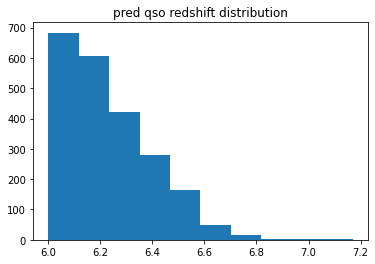

pred qsos z-band distribution:


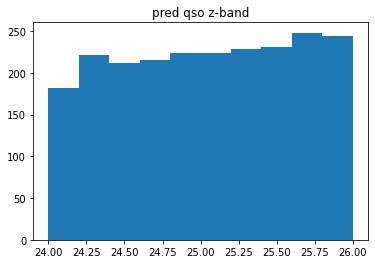

pred qsos Y-band distribution:


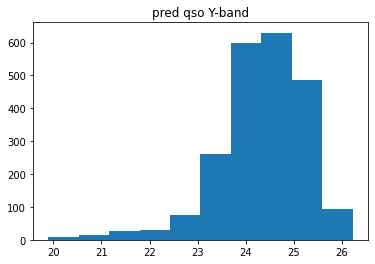

pred qsos J-band distribution:


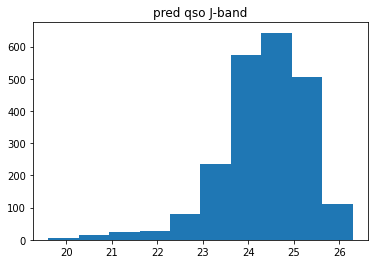

pred qsos H-band distribution:


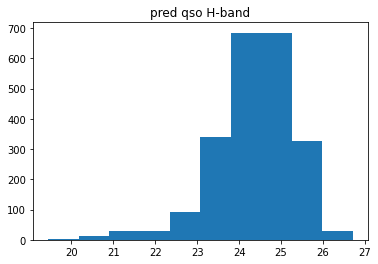

pred qsos F-band distribution:


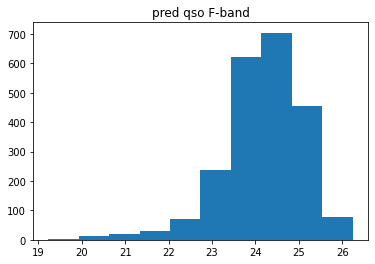

In [47]:
# qso distributions
print('predicted qsos redshift distribution:')
plt.hist(tp['z'])
plt.title('pred qso redshift distribution')
plt.show()
print('pred qsos z-band distribution:')
plt.hist(tp['z_LSST_mag'])
plt.title('pred qso z-band')
plt.show()
print('pred qsos Y-band distribution:')
plt.hist(tp['Y_WFI_mag'])
plt.title('pred qso Y-band')
plt.show()
print('pred qsos J-band distribution:')
plt.hist(tp['J_WFI_mag'])
plt.title('pred qso J-band')
plt.show()
print('pred qsos H-band distribution:')
plt.hist(tp['H_WFI_mag'])
plt.title('pred qso H-band')
plt.show()
print('pred qsos F-band distribution:')
plt.hist(tp['F_WFI_mag'])
plt.title('pred qso F-band')
plt.show()

missing qsos redshift distribution:


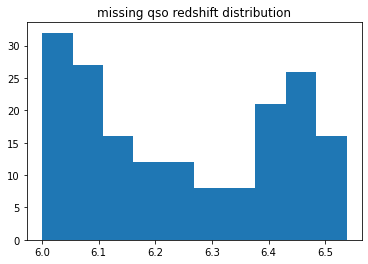

missing qsos z-band distribution:


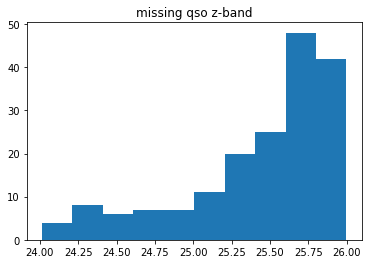

missing qsos Y-band distribution:


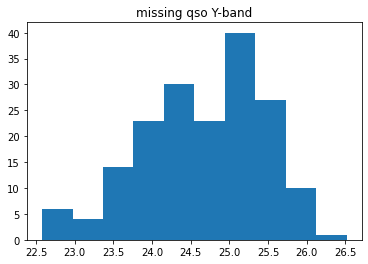

missing qsos J-band distribution:


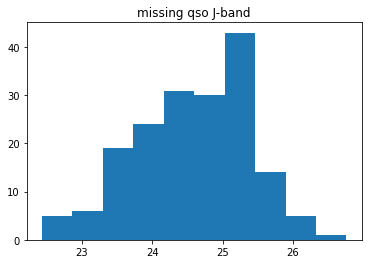

missing qsos H-band distribution:


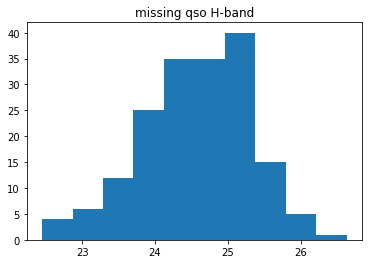

missing qsos F-band distribution:


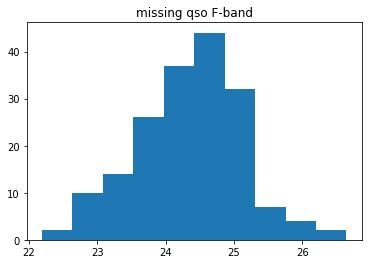

In [48]:
# missing qso distributions
print('missing qsos redshift distribution:')
plt.hist(fn['z'])
plt.title('missing qso redshift distribution')
plt.show()
print('missing qsos z-band distribution:')
plt.hist(fn['z_LSST_mag'])
plt.title('missing qso z-band')
plt.show()
print('missing qsos Y-band distribution:')
plt.hist(fn['Y_WFI_mag'])
plt.title('missing qso Y-band')
plt.show()
print('missing qsos J-band distribution:')
plt.hist(fn['J_WFI_mag'])
plt.title('missing qso J-band')
plt.show()
print('missing qsos H-band distribution:')
plt.hist(fn['H_WFI_mag'])
plt.title('missing qso H-band')
plt.show()
print('missing qsos F-band distribution:')
plt.hist(fn['F_WFI_mag'])
plt.title('missing qso F-band')
plt.show()

false positives spectral type distribution:


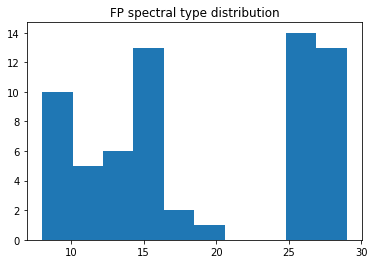

false positives z-band distribution:


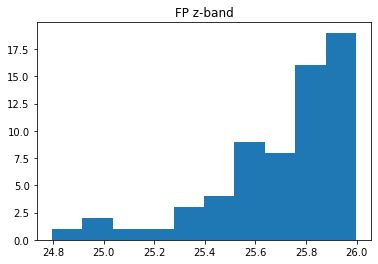

false positives Y-band distribution:


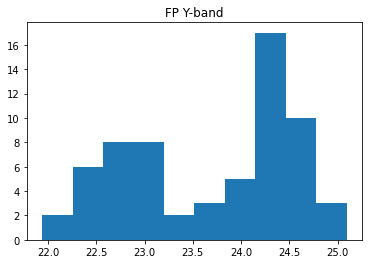

false positives J-band distribution:


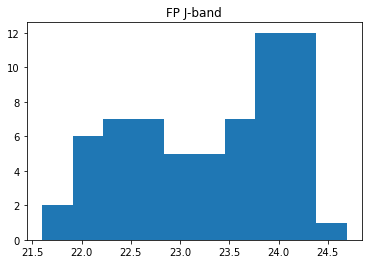

false positives H-band distribution:


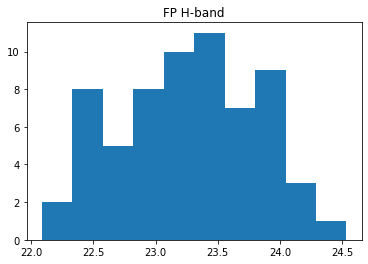

false positives F-band distribution:


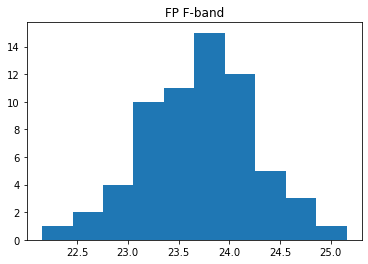

In [49]:
# false positives distribution
# FP distributions
print('false positives spectral type distribution:')
plt.hist(false_positive['spt'])
plt.title('FP spectral type distribution')
plt.show()
print('false positives z-band distribution:')
plt.hist(false_positive['z_LSST_mag'])
plt.title('FP z-band')
plt.show()
print('false positives Y-band distribution:')
plt.hist(false_positive['Y_WFI_mag'])
plt.title('FP Y-band')
plt.show()
print('false positives J-band distribution:')
plt.hist(false_positive['J_WFI_mag'])
plt.title('FP J-band')
plt.show()
print('false positives H-band distribution:')
plt.hist(false_positive['H_WFI_mag'])
plt.title('FP H-band')
plt.show()
print('false positives F-band distribution:')
plt.hist(false_positive['F_WFI_mag'])
plt.title('FP F-band')
plt.show()

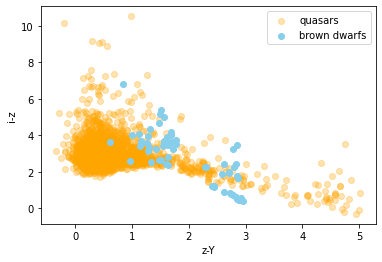

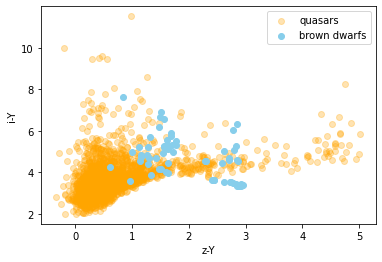

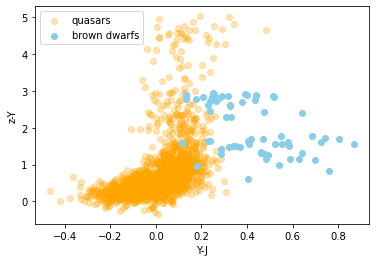

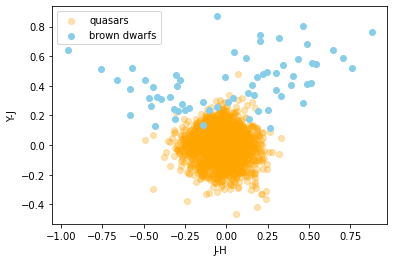

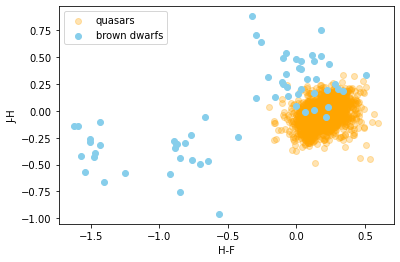

In [53]:
#  i-z vs z-Y
plt.scatter(tp['z_LSST_mag']-tp['Y_WFI_mag'], tp['i_LSST_mag']-tp['z_LSST_mag'], alpha=0.3, label='quasars', color='orange')
plt.scatter(false_positive['z_LSST_mag']-false_positive['Y_WFI_mag'], false_positive['i_LSST_mag']-false_positive['z_LSST_mag'], label='brown dwarfs', color='skyblue')
plt.xlabel('z-Y')
plt.ylabel('i-z')
plt.legend()
plt.show()

# i-Y bs z-Y
plt.scatter(tp['z_LSST_mag']-tp['Y_WFI_mag'], tp['i_LSST_mag']-tp['Y_WFI_mag'], alpha=0.3, label='quasars', color='orange')
plt.scatter(false_positive['z_LSST_mag']-false_positive['Y_WFI_mag'], false_positive['i_LSST_mag']-false_positive['Y_WFI_mag'], label='brown dwarfs', color='skyblue')
plt.xlabel('z-Y')
plt.ylabel('i-Y')
plt.legend()
plt.show()

#  z-Y vs Y-J
plt.scatter(tp['Y_WFI_mag']-tp['J_WFI_mag'], tp['z_LSST_mag']-tp['Y_WFI_mag'], alpha=0.3, label='quasars', color='orange')
plt.scatter(false_positive['Y_WFI_mag']-false_positive['J_WFI_mag'], false_positive['z_LSST_mag']-false_positive['Y_WFI_mag'], label='brown dwarfs', color='skyblue')
plt.xlabel('Y-J')
plt.ylabel('z-Y')
plt.legend()
plt.show()

# Y-J vs J-H
plt.scatter(tp['J_WFI_mag']-tp['H_WFI_mag'], tp['Y_WFI_mag']-tp['J_WFI_mag'], alpha=0.3, label='quasars', color='orange')
plt.scatter(false_positive['J_WFI_mag']-false_positive['H_WFI_mag'], false_positive['Y_WFI_mag']-false_positive['J_WFI_mag'], label='brown dwarfs', color='skyblue')
plt.xlabel('J-H')
plt.ylabel('Y-J')
plt.legend()
plt.show()

# J-H vs H-F
plt.scatter(tp['H_WFI_mag']-tp['F_WFI_mag'], tp['J_WFI_mag']-tp['H_WFI_mag'], alpha=0.3, label='quasars', color='orange')
plt.scatter(false_positive['H_WFI_mag']-false_positive['F_WFI_mag'], false_positive['J_WFI_mag']-false_positive['H_WFI_mag'], label='brown dwarfs', color='skyblue')
plt.xlabel('H-F')
plt.ylabel('J-H')
plt.legend()
plt.show()